# Ideas
1. Analyze frequency space of delta-v
    + Negative delta-Vs could represent events of resistance to flow (attachment)
2. Compare velocities at matched time points
    + Flow conditions could be inconsistent, we would want to observe
3. Annotation review (check for errors and anomalies)
4. Time vs Point ID
    + Time is global but how can we use this with the PID variable to represent time local to the track
5. Can we find characterizable differences between attached/unattached cells?

# MTrackJ Data Columns

1. **Nr** Unique ID
2. **TID** Track ID
3. **PID** Point ID
4. **x**
5. **y**
6. **t** Time
7. **l** Pixel intensity (Not sure if we can use this)
8. **Len** Total length of track
9. **D2S** Distance from first point of track to current point (shortest distance: displacement)
10. **D2r** Same as **D2S** but for a specified reference point (Currently not using this feature)
11. **D2P** Distance of current point to previous point
12. **v** Velocity calculated by last displacement vector divided by time interval 
13. **α** Angle displacement relative to previous point. (0 deg = East, +90 = South, etc.)
14. **Δα** Change in angle displacement

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%matplotlib inline

# Load in Data

In [4]:
csv = "ln5bind_points.csv"
data = pd.read_csv(csv)
data.set_index("Nr")
data.head(10)

,Nr,TID,PID,x [pixel],y [pixel],t [sec],I [val],Len [pixel],D2S [pixel],D2R [pixel],D2P [pixel],v [pixel/sec],α [deg],Δα [deg]
0,1,1,1,167,13,43,33505,0.000,0.000,NaN,NaN,NaN,NaN,NaN
1,2,1,2,165,48,44,22945,35.057,35.057,NaN,35.057,35.057,93.270,NaN
2,3,1,3,162,94,45,29091,81.155,81.154,NaN,46.098,46.098,93.731,0.461
3,4,1,4,163,127,46,21050,114.170,114.070,NaN,33.015,33.015,88.264,-5.467
4,5,1,5,163,165,47,27345,152.170,152.053,NaN,38.000,38.000,90.000,1.736
5,6,1,6,161,195,48,18616,182.237,182.099,NaN,30.067,30.067,93.814,3.814
6,7,1,7,162,233,49,18992,220.250,220.057,NaN,38.013,38.013,88.493,-5.322
7,8,1,8,161,264,50,21468,251.266,251.072,NaN,31.016,31.016,91.848,3.355
8,9,1,9,159,297,51,18960,284.326,284.113,NaN,33.061,33.061,93.468,1.621
9,10,1,10,161,323,52,29957,310.403,310.058,NaN,26.077,26.077,85.601,-7.867


# Subset and Rename columns of interest

In [59]:
columns_of_interest = ["TID", "PID","x [pixel]", "y [pixel]","t [sec]", "v [pixel/sec]"]
new_cols = ["x","y","t","v"]
data = data[columns_of_interest]

# Rename columns
replace_cols = dict(zip(columns_of_interest[2:],new_cols))
data = data.rename(columns=replace_cols)
data.head(10)

,TID,PID,x,y,t,v
0,1,1,167,13,43,NaN
1,1,2,165,48,44,35.057
2,1,3,162,94,45,46.098
3,1,4,163,127,46,33.015
4,1,5,163,165,47,38.000
5,1,6,161,195,48,30.067
6,1,7,162,233,49,38.013
7,1,8,161,264,50,31.016
8,1,9,159,297,51,33.061
9,1,10,161,323,52,26.077


# Add a delta-v column, and attached column

In [60]:
data["dv"] = data["v"].diff()

In [61]:
data["attached"] = data["TID"]>50

# Separate attached/non-attached cells
1. I annotated these 1-50 non-attached and 51-100 attached
2. Programmatic way would utilize track having a t=2000 point

In [62]:
attached = data[data["TID"] > 50]
zoomers = data[data["TID"] <= 50]

# Velocities

In [63]:
data["v"].describe()

count    1861.000000
mean       20.203069
std        10.986683
min         0.000000
25%        15.297000
50%        20.025000
75%        25.020000
max       154.081000
Name: v, dtype: float64

# Observations

It seems that unattached T cells have a huuuge range of velocities, but the means of both populations is close to
the same. Maybe there is a temporal component that is charecteristic. The attached population definitely expands
its range toward the lower end.

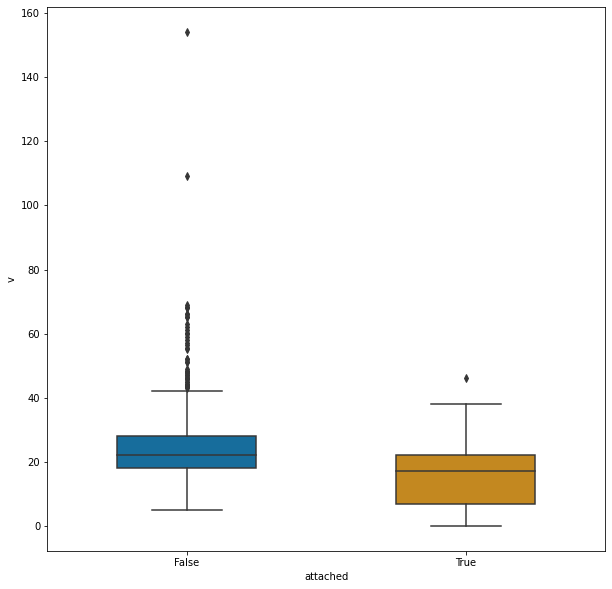

In [64]:
fig,ax = plt.subplots(figsize= (10,10))
bplot = sns.boxplot(ax= ax, 
                    y='v', x='attached', 
                    data=data, 
                    width=0.5,
                    palette="colorblind")

There might be some issues here with the number of PID per track for attached vs non-attached that is leading to this data.
Attached cells present more points because they remain on the screen for longer leading to issues in population sizes.
Need to choose metric that compensates/takes this into account.

Text(0.5, 1.0, 'Number of Points per Track')

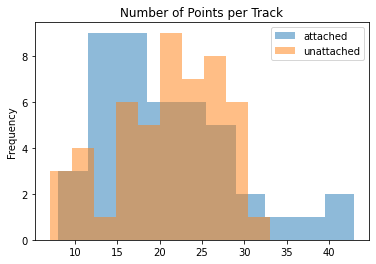

In [99]:
fig,ax = plt.subplots()
attached.groupby("TID")["PID"].count().plot.hist(ax=ax,alpha=0.5,bins=10,label="attached")
zoomers.groupby("TID")["PID"].count().plot.hist(ax=ax,alpha=0.5,bins=10,label="unattached")
ax.legend(loc="upper right")
ax.set_title("Number of Points per Track")

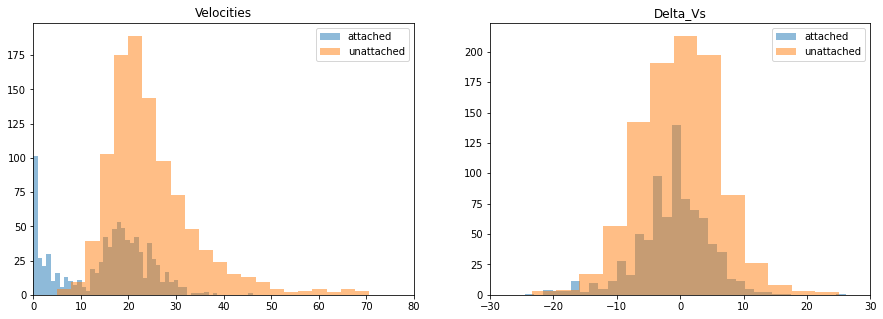

In [74]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

#ax[0].hist(data["v"],alpha=0.5,bins=50, label="total")
ax[0].hist(attached["v"],alpha=0.5,bins=50, label="attached")
ax[0].hist(zoomers["v"],alpha=0.5, bins=50, label="unattached")
ax[0].set_xlim(0,80)
ax[0].set_title("Velocities")

#ax[1].hist(data["dv"],alpha=0.5,bins=50, label="total")
ax[1].hist(attached["dv"],alpha=0.5,bins=50, label="attached")
ax[1].hist(zoomers["dv"],alpha=0.5, bins=50, label="unattached")
ax[1].set_xlim(-30,30)
ax[1].set_title("Delta_Vs")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
plt.show()

<AxesSubplot:>

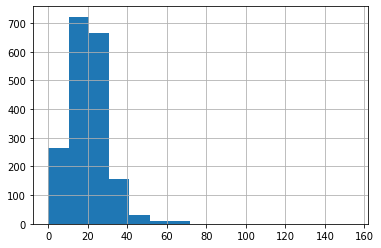

In [66]:
bins = round(data["v"].max()/10)
data["v"].hist(bins=bins)

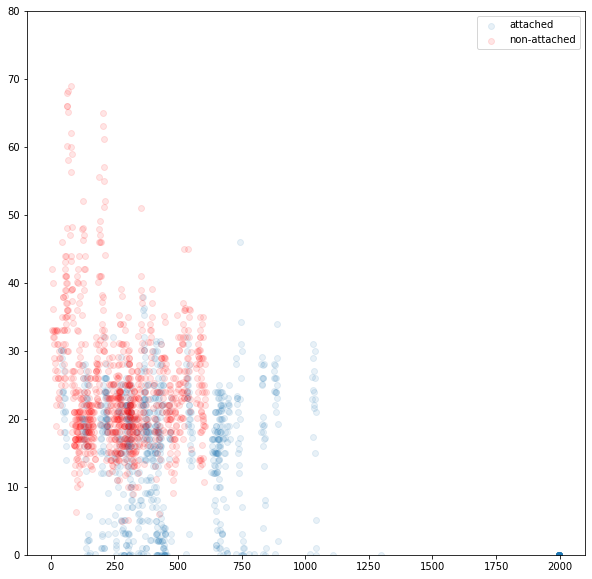

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(attached["t"], attached["v"], alpha = 0.1,label="attached")
ax.scatter(zoomers["t"], zoomers["v"], color="red",alpha=0.1,label="non-attached")
ax.set_ylim([0,80])
ax.legend(loc="upper right")
plt.show()

In [180]:
data["PID"].describe()

count    1955.000000
mean       12.132992
std         7.924006
min         1.000000
25%         6.000000
50%        11.000000
75%        17.000000
max        43.000000
Name: PID, dtype: float64

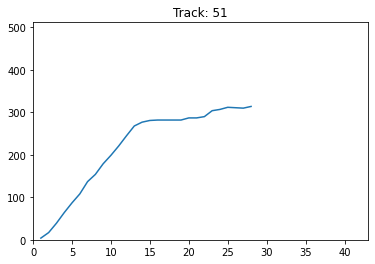

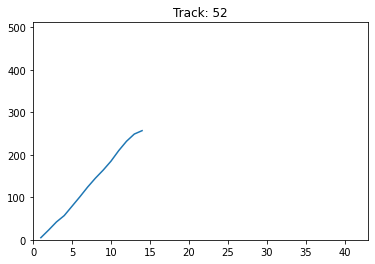

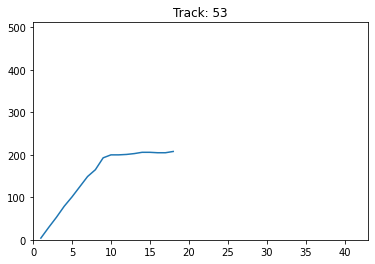

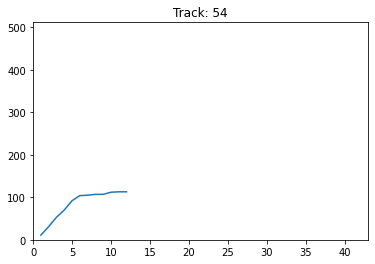

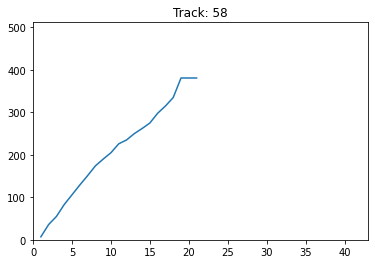

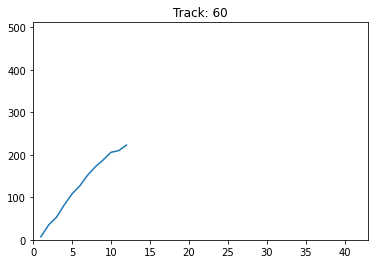

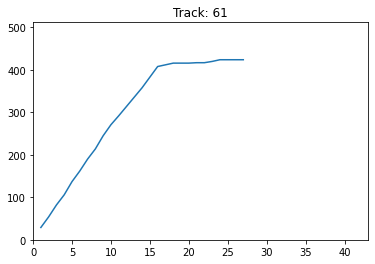

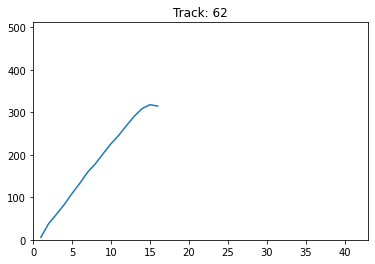

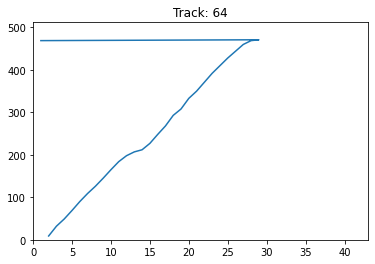

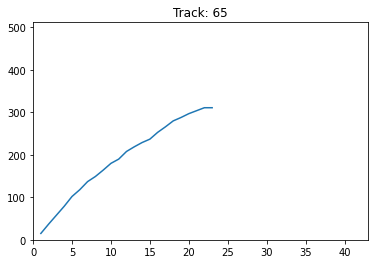

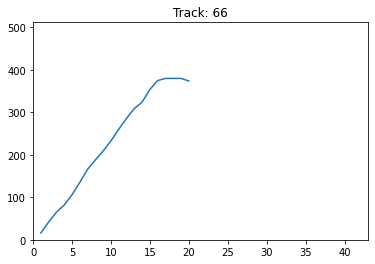

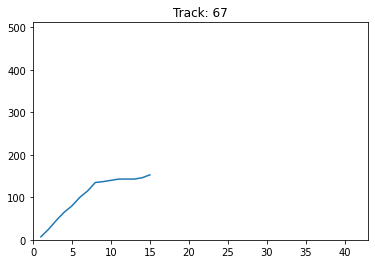

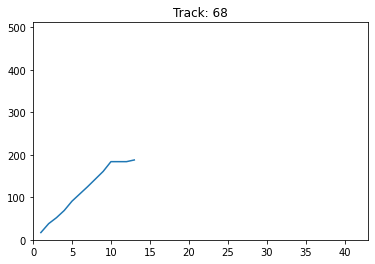

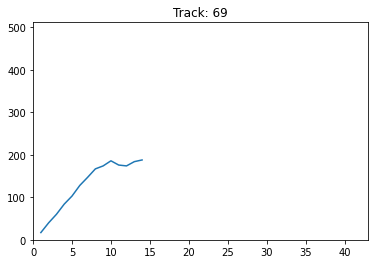

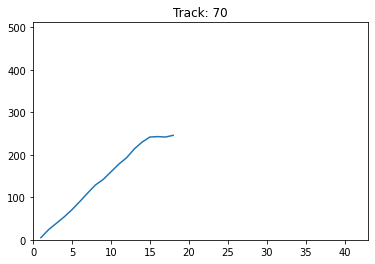

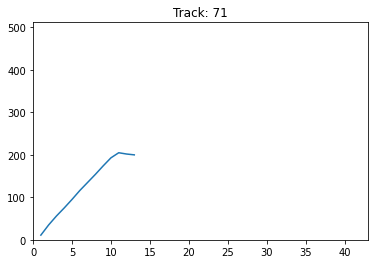

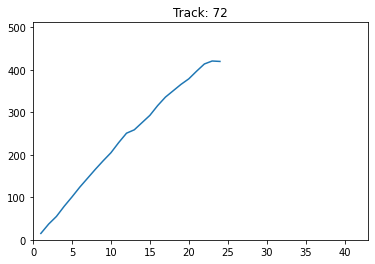

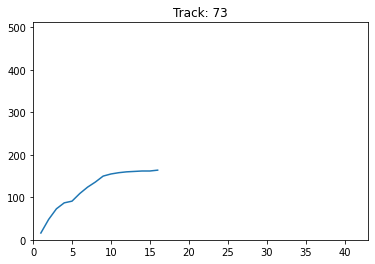

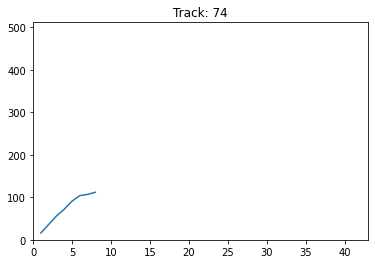

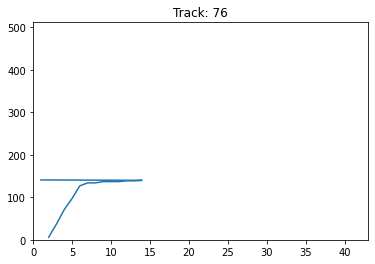

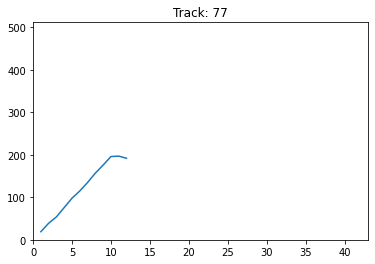

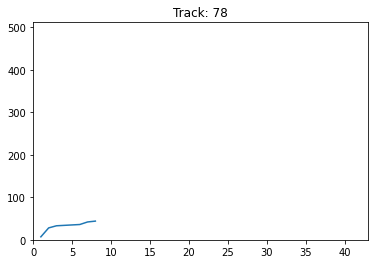

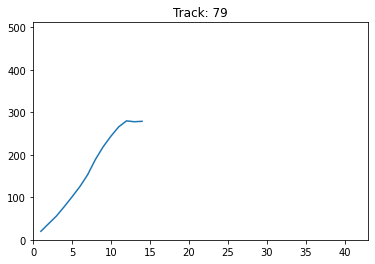

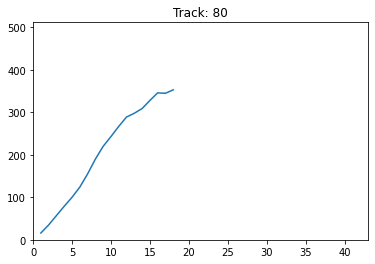

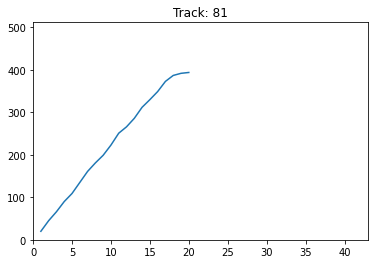

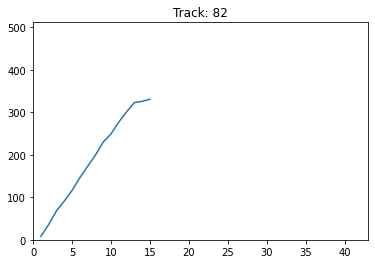

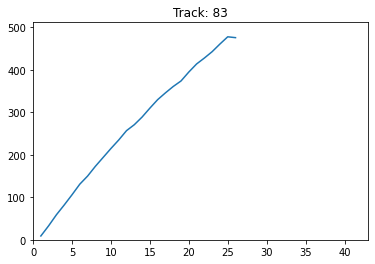

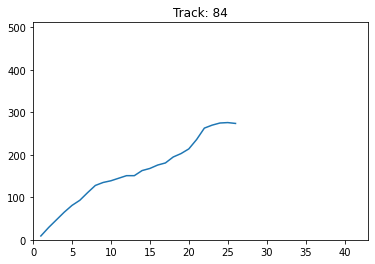

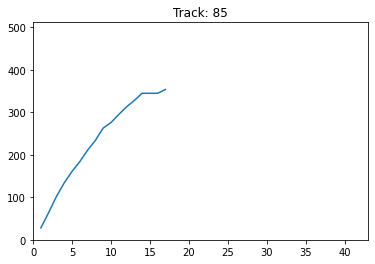

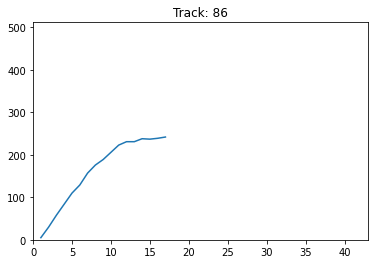

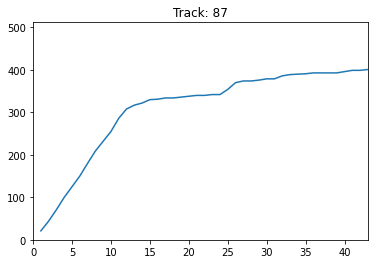

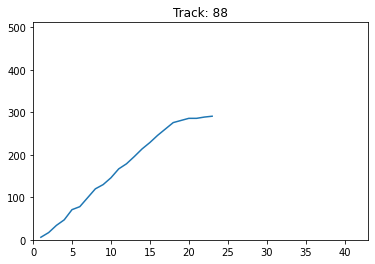

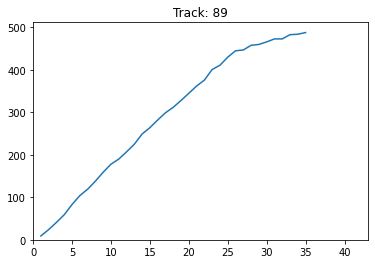

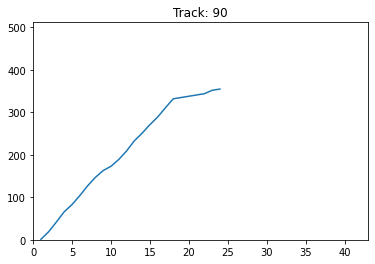

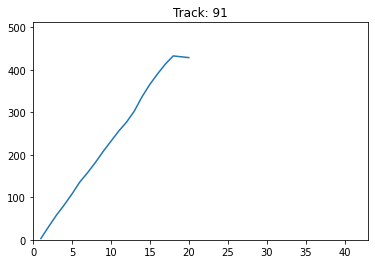

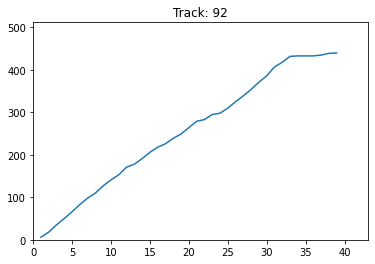

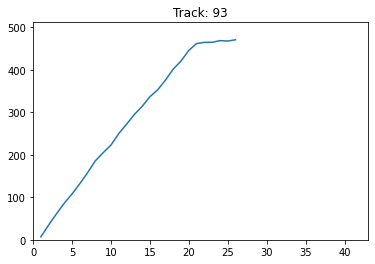

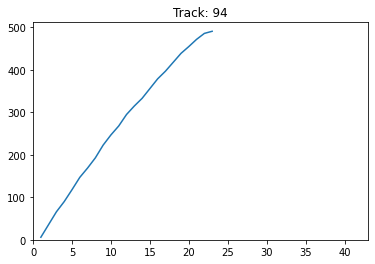

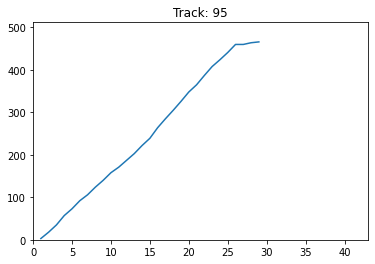

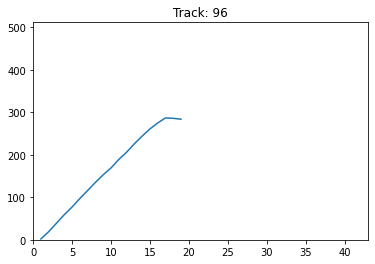

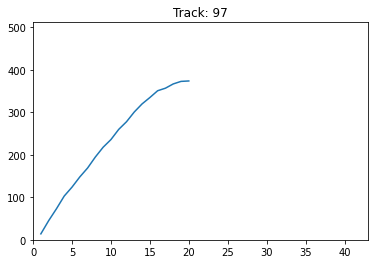

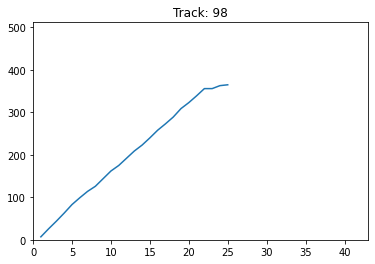

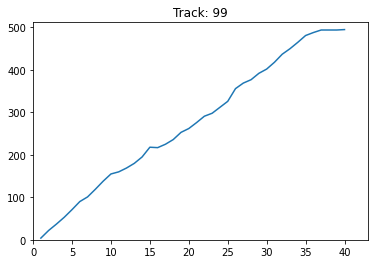

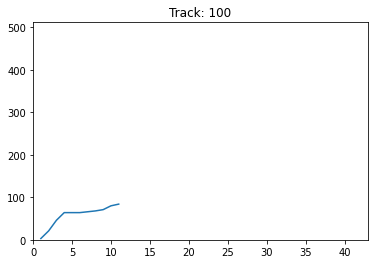

In [68]:
def plot_yvel(df,title):
    fig,ax = plt.subplots()
    #ax.plot(df["y [pixel]"], df["v [pixel/sec]"])
    #ax.plot(df["t [sec]"], df["y [pixel]"])
    ax.plot(df["PID"], df["y"])
    ax.set_xlim([0,43])
    ax.set_ylim([0,512])
    ax.set_title(f"Track: {title}")
    plt.show()
for thing, track in attached.groupby("TID"):
    plot_yvel(track,thing)

# Notes
## Errors in Annotating:
+ 64
+ 76

# Delta V

In [69]:
data["dv"].describe()

count    1767.000000
mean       -0.649398
std         7.261451
min       -94.081000
25%        -4.000000
50%        -0.100000
75%         3.026000
max        92.073000
Name: dv, dtype: float64

<AxesSubplot:>

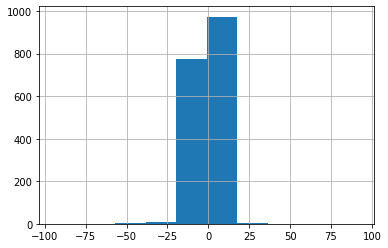

In [70]:
bins = round(data["dv"].max()/10)
data["dv"].hist()

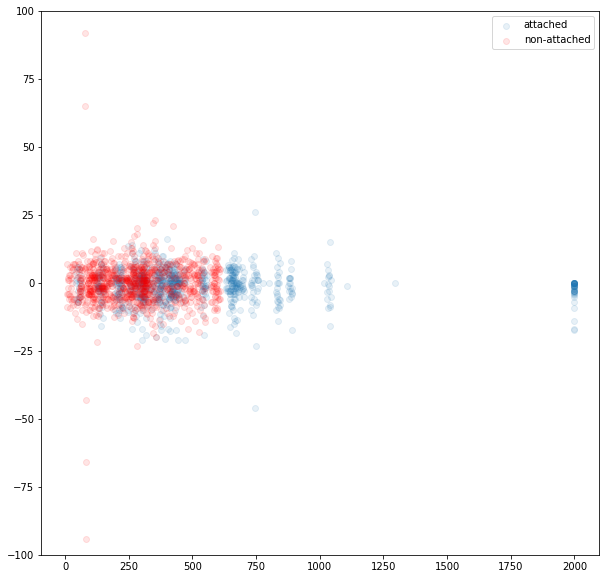

In [71]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(attached["t"], attached["dv"], alpha = 0.1,label="attached")
ax.scatter(zoomers["t"], zoomers["dv"], color="red",alpha=0.1,label="non-attached")
ax.set_ylim([-100,100])
ax.legend(loc="upper right")
plt.show()

# Outliers?

In [72]:
fast_bois = data["v"] > 60
data[fast_bois]

,TID,PID,x,y,t,v,dv,attached
63,5,2,87,100,63,60.208,NaN,False
64,5,3,86,166,64,66.008,5.800,False
65,5,4,85,232,65,66.008,0.000,False
66,5,5,84,300,66,68.007,1.999,False
67,5,6,80,365,67,65.123,-2.884,False
69,5,8,83,491,69,68.184,10.150,False
74,6,5,375,266,80,109.000,64.955,False
82,7,2,85,74,80,69.007,NaN,False
252,15,2,329,126,206,65.069,NaN,False
253,15,3,326,189,207,63.071,-1.998,False


In [89]:
data[data["TID"] == 27]

,TID,PID,x [pixel],y [pixel],t [sec],v [pixel/sec],delta_v
511,27,1,326,32,77,NaN,NaN
512,27,2,320,88,78,56.321,NaN
513,27,3,321,150,79,62.008,5.687
514,27,4,316,304,80,154.081,92.073
515,27,5,316,364,81,60.000,-94.081
516,27,6,317,423,82,59.008,-0.992
517,27,7,312,471,83,48.260,-10.748


In [73]:
def plot_vdelv(df,time=False):
    x_axis = df["PID"] if time is False else df["t [sec]"]
    fig,ax = plt.subplots()
    ax.plot(x_axis, df["v"])
    ax.bar(x_axis, df["dv"], 
                 color=(df["dv"] > 0).map({True: "Blue", False: "Red"}))
    plt.show()

# Velocities and Delta-Vs

1. Variability in number of points
2. Freq space of delta-vs

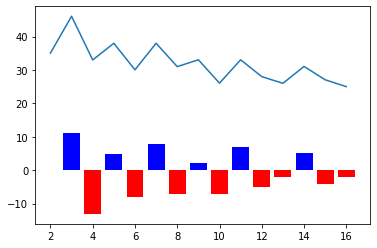

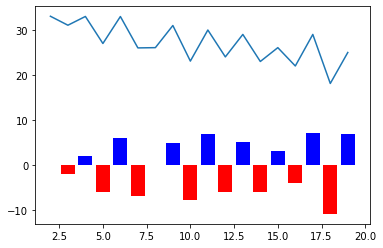

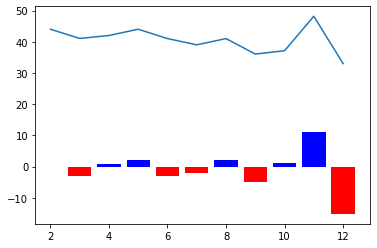

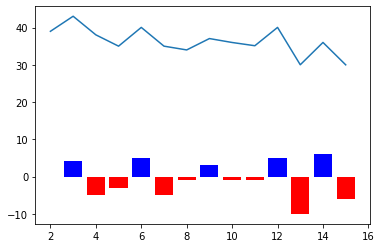

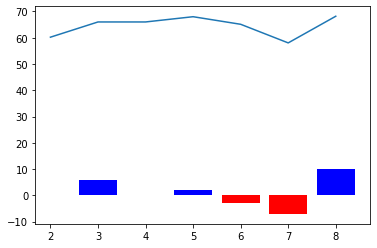

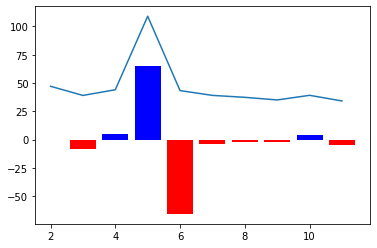

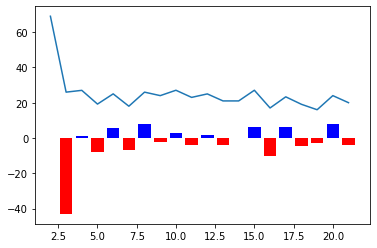

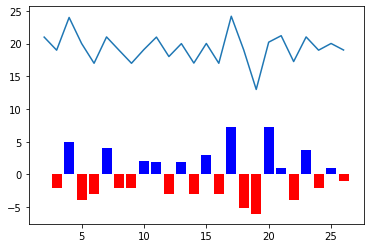

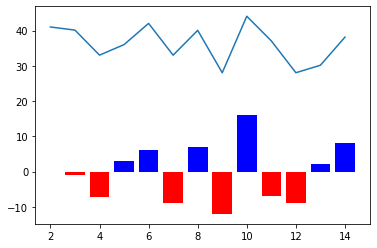

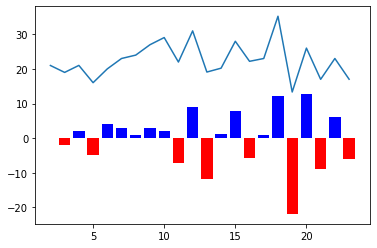

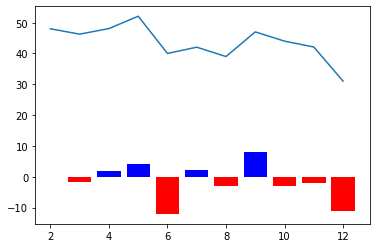

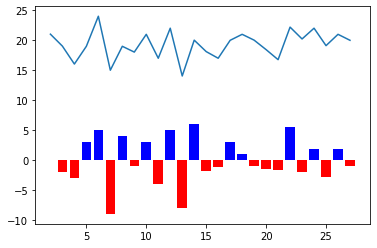

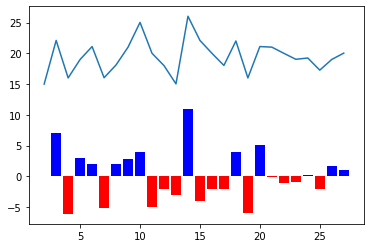

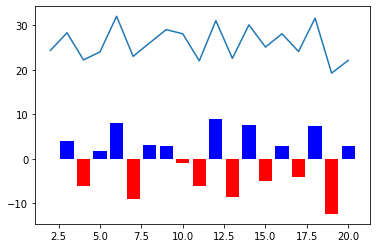

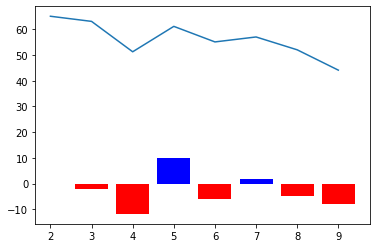

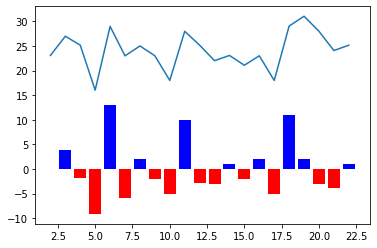

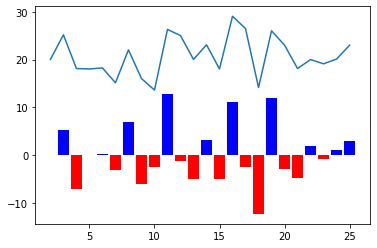

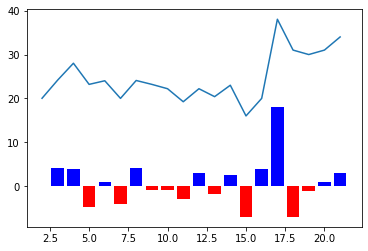

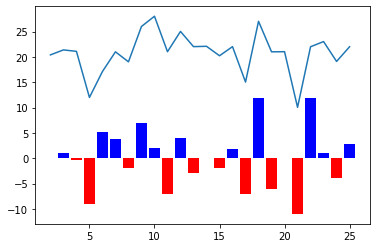

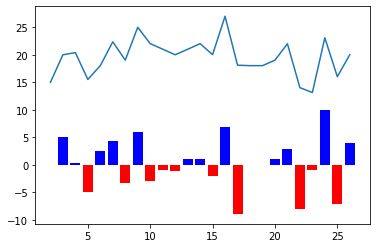

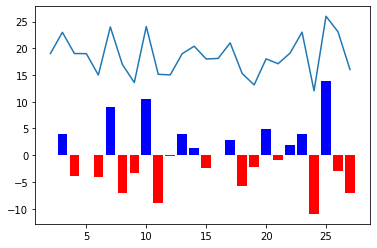

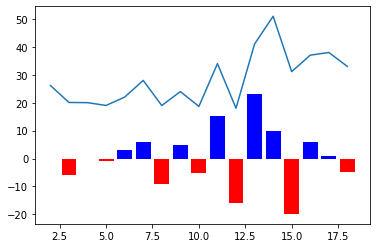

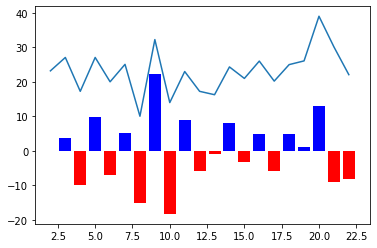

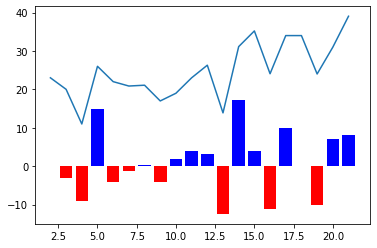

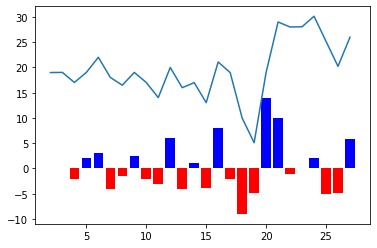

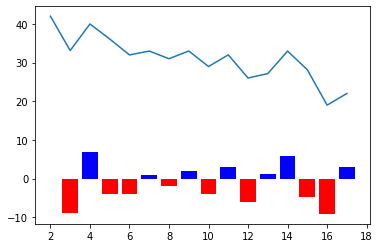

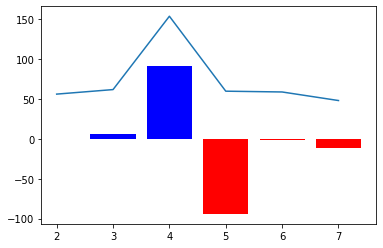

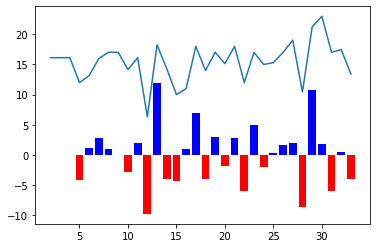

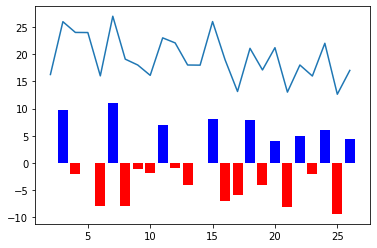

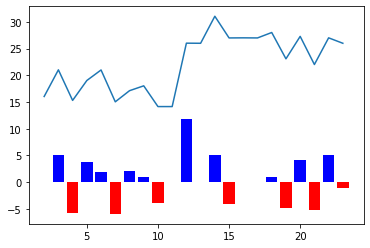

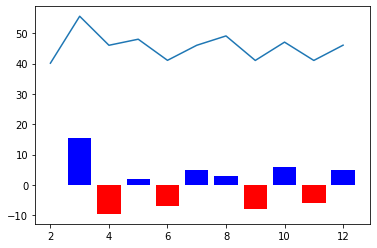

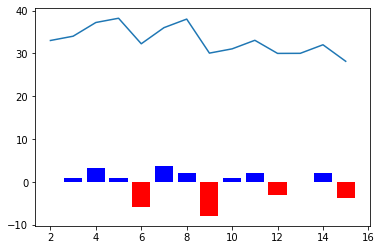

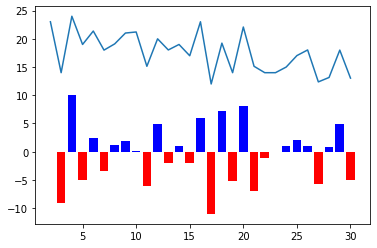

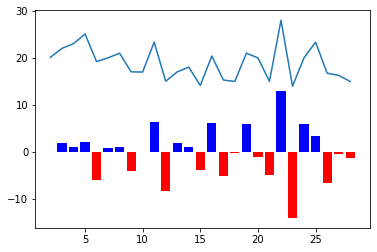

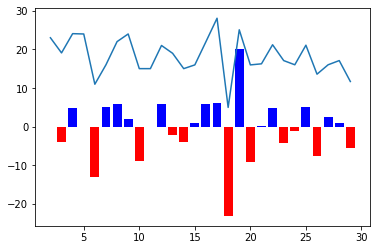

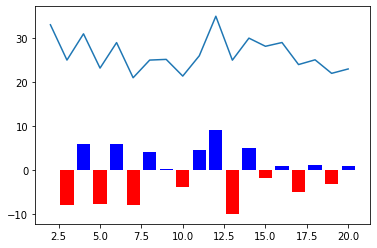

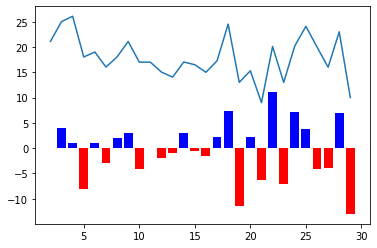

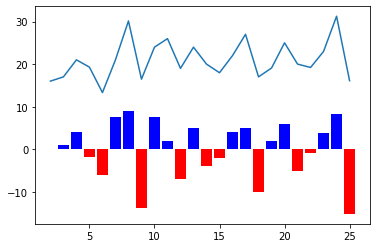

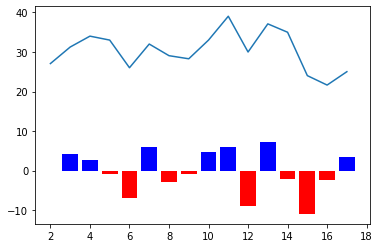

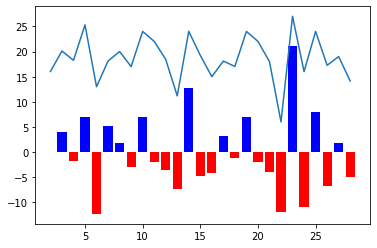

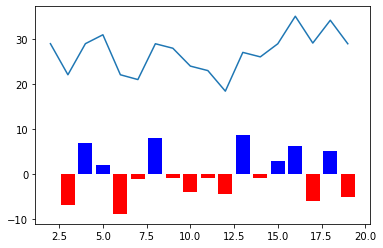

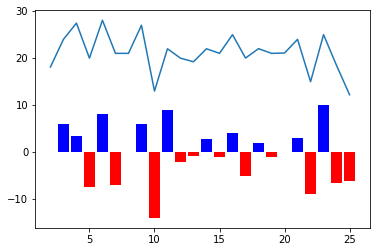

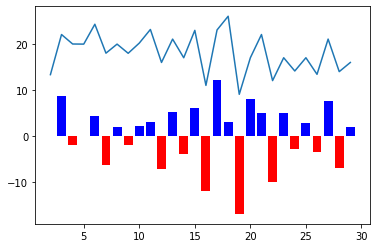

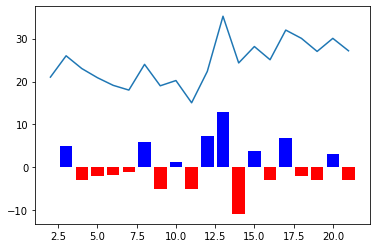

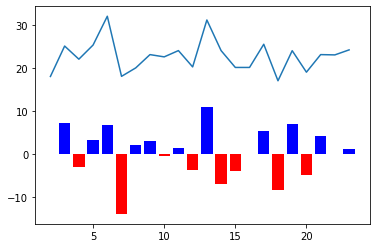

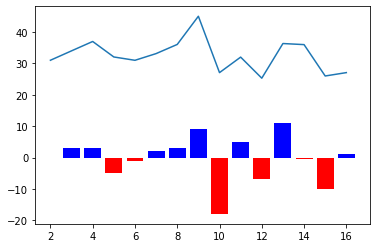

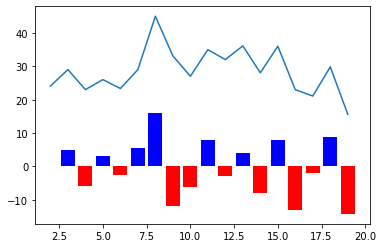

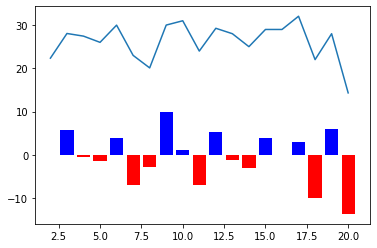

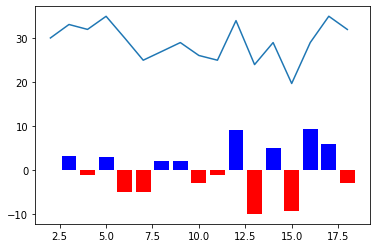

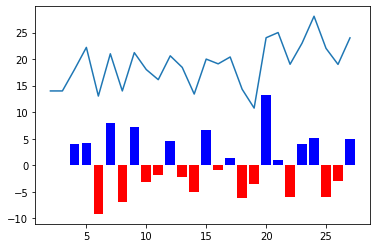

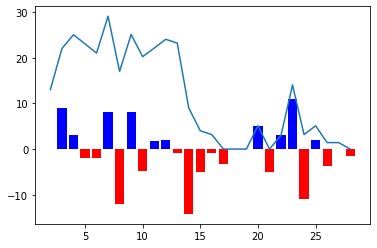

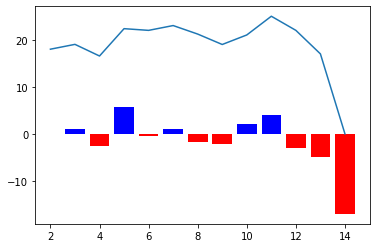

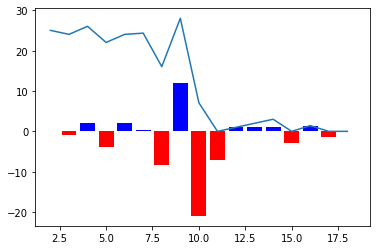

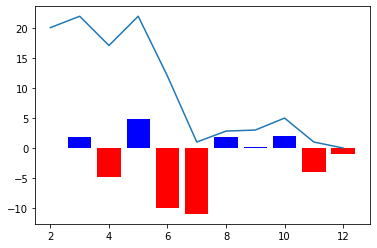

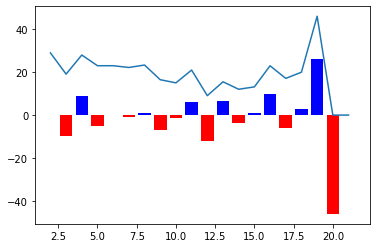

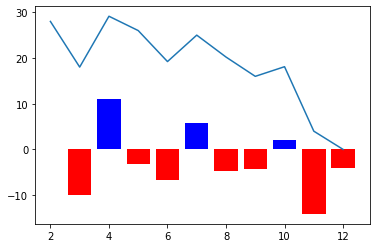

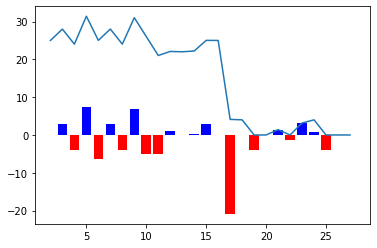

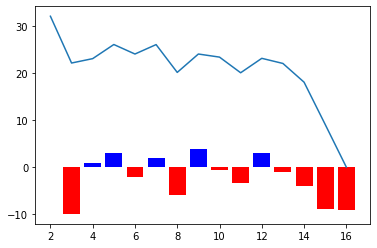

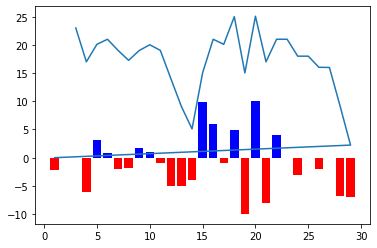

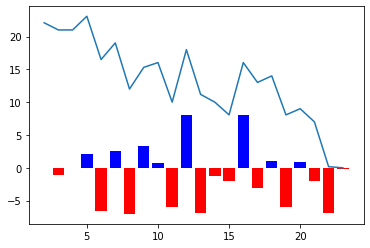

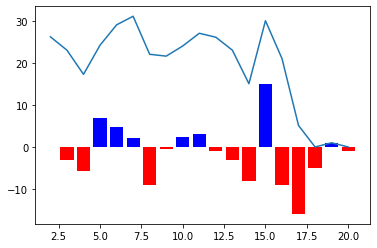

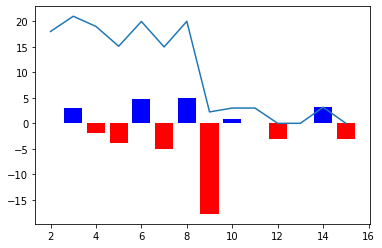

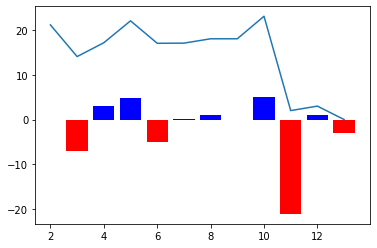

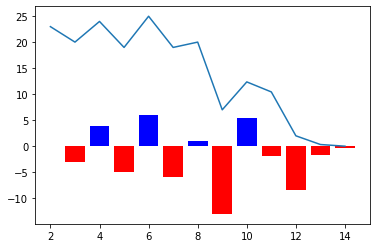

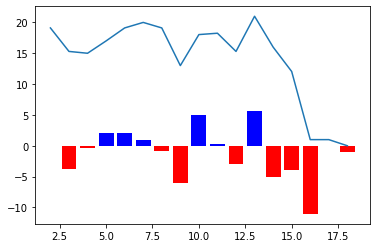

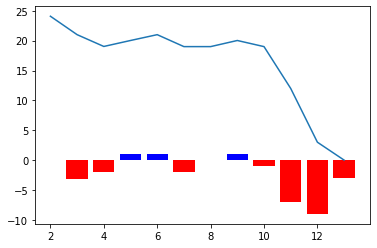

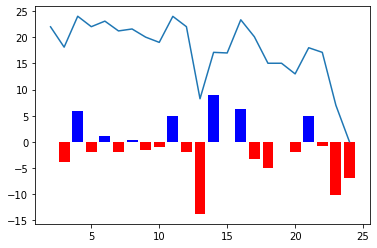

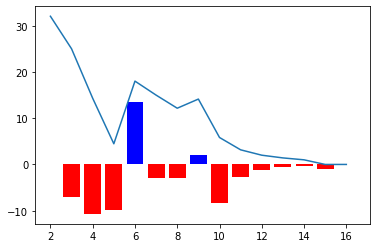

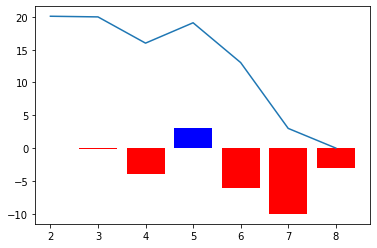

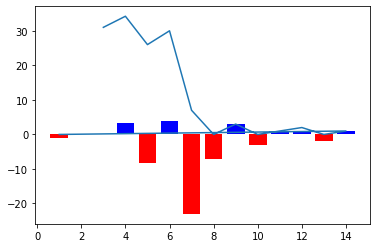

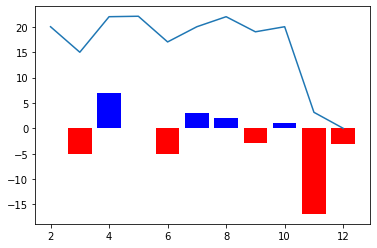

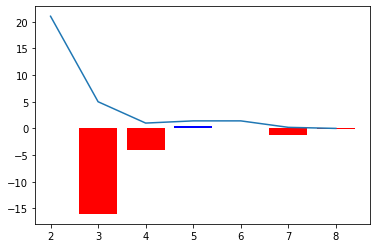

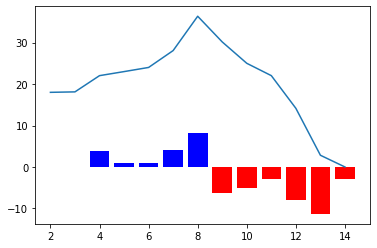

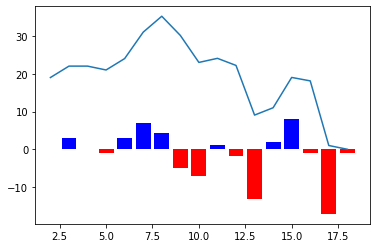

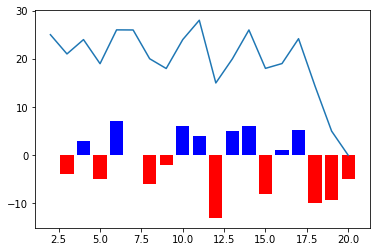

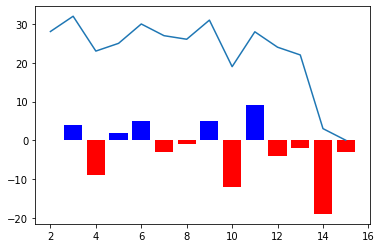

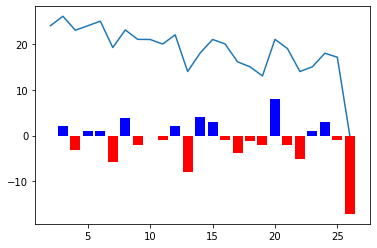

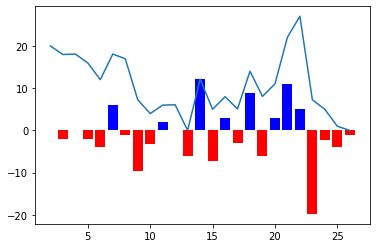

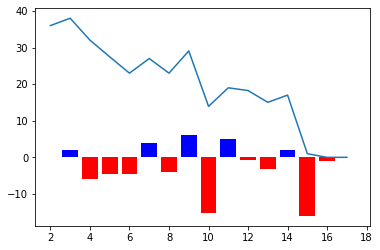

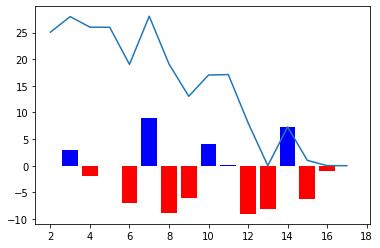

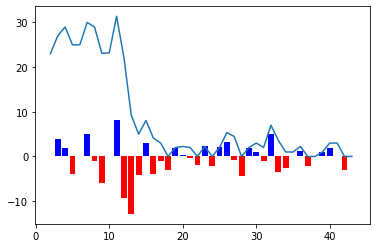

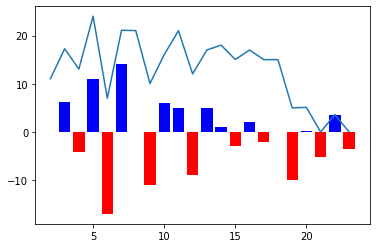

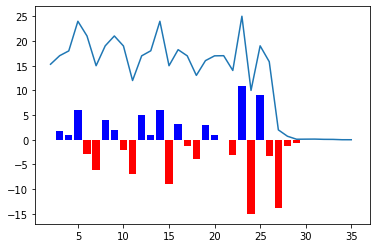

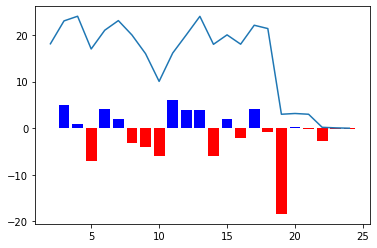

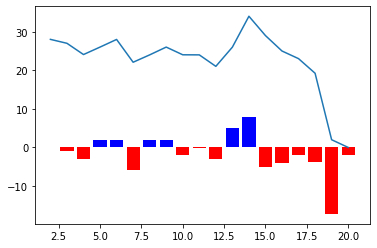

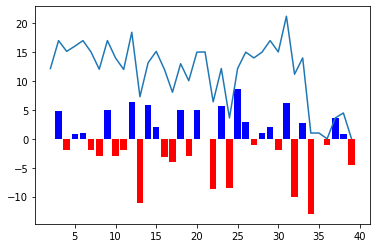

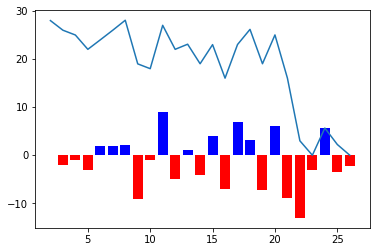

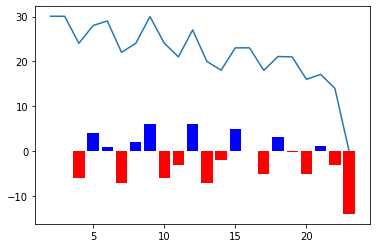

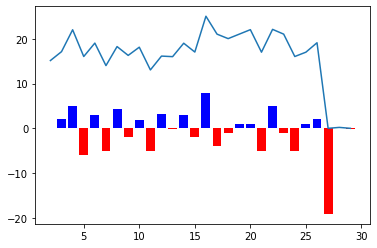

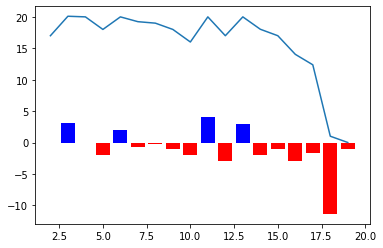

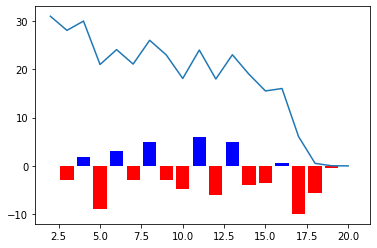

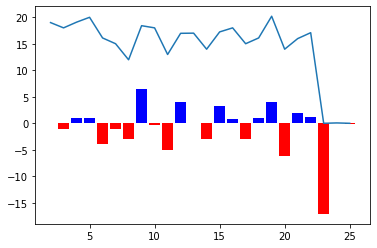

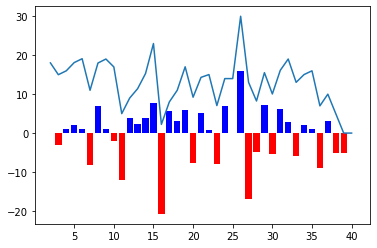

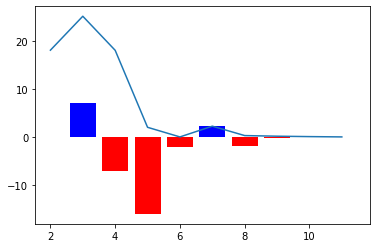

In [128]:
tracks = data.groupby("TID")
for thing,track in tracks:
    plot_vdelv(track)